## CAPM
$E(r_i) - r_f = \beta_i(E(r_m)-r_f)$

In [1]:
import yfinance as yf 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

plt.style.use('bmh')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# use S&P500 as benchmark
data = yf.download('AMZN ^GSPC', period='10y', interval='1d', auto_adjust=True, progress=False)
data = data.Close
data = data.resample('M').last().iloc[:-1, :] # last row is not full month
data_ret = np.log(data/data.shift(1)).dropna()
data_ret.rename(columns={'^GSPC':'SnP500'}, inplace=True)
print(data_ret.shape)
data_ret.head()

(119, 2)


,AMZN,SnP500
Date,,
2012-03-31,0.119556,0.030851
2012-04-30,0.135517,-0.007526
2012-05-31,-0.085437,-0.064699
2012-06-30,0.070010,0.038793
2012-07-31,0.021446,0.012519


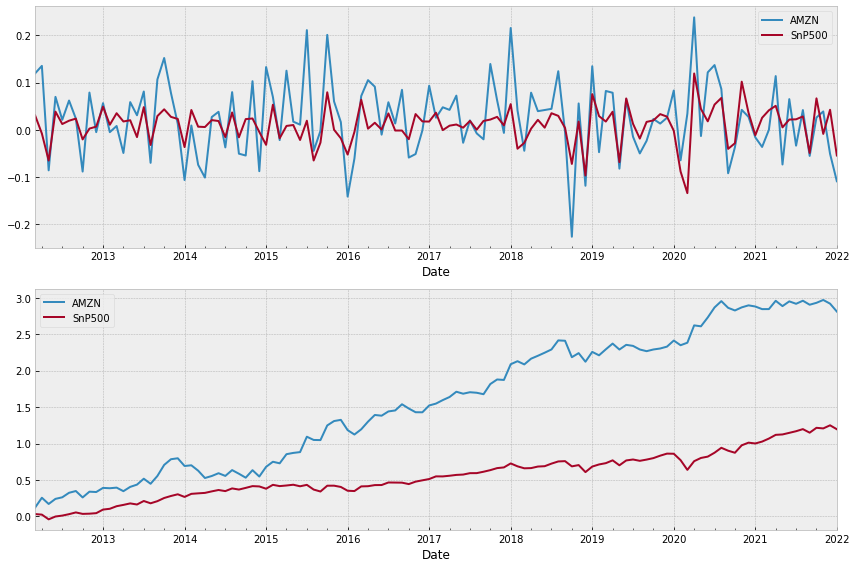

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

data_ret.plot(ax=ax[0])
data_ret.cumsum().plot(ax=ax[1])

plt.tight_layout()
plt.show()

In [5]:
# assume risk-free rate = 0
X = data_ret.copy(deep=True)
y = X.pop('AMZN')
X = sm.add_constant(X)

In [6]:
capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     60.65
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           3.04e-12
Time:                        11:28:12   Log-Likelihood:                 159.68
No. Observations:                 119   AIC:                            -315.4
Df Residuals:                     117   BIC:                            -309.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.006      1.917      0.0

In [7]:
# get risk-free rate
# 13 Week Treasury Bill (^IRX) (3-month)
rf = yf.download('^IRX', period='10y', interval='1d', auto_adjust=True, progress=False)
rf = rf.resample('M').last().Close.div(100)
# convert 3-month rate to 1-month rate
rf = ((1 + rf*90/360)**(30/90)) -1
rf = rf[data_ret.index]
rf 

Date
2012-03-31    0.000054
2012-04-30    0.000075
2012-05-31    0.000050
2012-06-30    0.000067
2012-07-31    0.000083
                ...   
2021-09-30    0.000023
2021-10-31    0.000040
2021-11-30    0.000040
2021-12-31    0.000027
2022-01-31    0.000144
Freq: M, Name: Close, Length: 119, dtype: float64

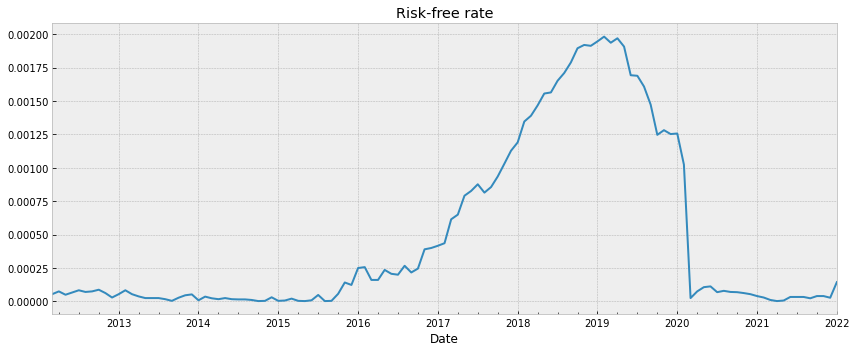

In [8]:
rf.plot(figsize=(12,5))
plt.title('Risk-free rate')
plt.tight_layout()
plt.show()

In [9]:
X = data_ret.copy(deep=True)
y = X.pop('AMZN') - rf 
X = X.sub(rf, axis=0)
X = sm.add_constant(X)

In [10]:
capm_model_2 = sm.OLS(y, X).fit()
print(capm_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     60.81
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           2.88e-12
Time:                        11:28:13   Log-Likelihood:                 159.68
No. Observations:                 119   AIC:                            -315.4
Df Residuals:                     117   BIC:                            -309.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0117      0.006      1.938      0.0